In [46]:
import sqlite3 as sq
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
q1 = """
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table", "view");
"""

def run_query(q):
    with sq.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)


def run_command(command):
    with sq.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(command)

def show_table(q):
    return run_query(q)

show_table(q1)

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [48]:
q_genre_analysis = """
WITH USA_purchase AS
(
SELECT
    il.track_id,
    il.quantity,
    i.billing_country
FROM invoice_line il
INNER JOIN invoice i
ON i.invoice_id = il.invoice_id
WHERE i.billing_country = "USA"
)
 
SELECT
    g.name as genre_name,
    SUM(up.quantity) as number_of_purchases,
    CAST(SUM(up.quantity) as FLOAT) / 
    (SELECT SUM(quantity) FROM USA_purchase) as pct_of_total
FROM USA_purchase up
INNER JOIN track t
ON t.track_id = up.track_id
INNER JOIN genre g
ON g.genre_id = t.genre_id
GROUP BY genre_name
ORDER BY number_of_purchases DESC;
"""

show_table(q_genre_analysis)

,genre_name,number_of_purchases,pct_of_total
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [49]:
genre_sales_usa = run_query(q_genre_analysis)
genre_sales_usa = genre_sales_usa.dropna()
genre_sales_usa.head()

,genre_name,number_of_purchases,pct_of_total
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253


In [50]:
fig = plt.figure()
ax = fig.add_subplot()

genre_sales_usa.set_index("genre_name", drop=True, inplace=True)
genre_sales_usa.head()

,number_of_purchases,pct_of_total
genre_name,,
Rock,561,0.533777
Alternative & Punk,130,0.123692
Metal,124,0.117983
R&B/Soul,53,0.050428
Blues,36,0.034253


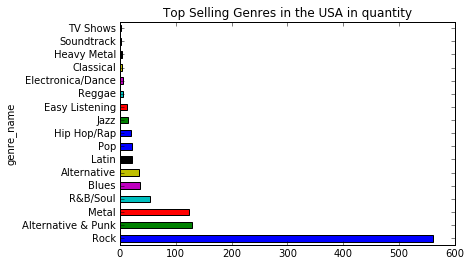

In [51]:
genre_sales_usa["number_of_purchases"].plot.barh(title="Top Selling Genres in the USA in quantity")

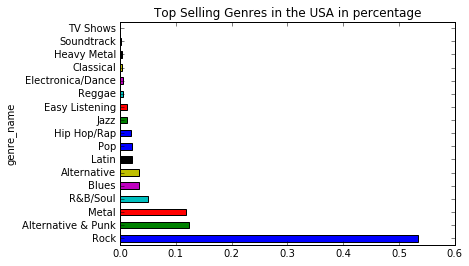

In [52]:
genre_sales_usa["pct_of_total"].plot.barh(title="Top Selling Genres in the USA in percentage")

Top three best selling genres:
 - Rock
 - Alternative & Punk
 - Metal

In [53]:
q_artist_recomm = """
WITH track_album_artist AS
(
    SELECT
        at.name as artist_name,
        il.quantity as number_of_purchase,
        t.track_id,
        t.album_id,
        abm.title as album_title,
        g.name as genre_name
    FROM track t
    INNER JOIN album abm ON t.album_id = abm.album_id
    INNER JOIN artist at ON at.artist_id = abm.artist_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    )

SELECT 
    artist_name,
    COUNT(track_id),
    album_title,
    genre_name
FROM track_album_artist taa
GROUP BY artist_name
ORDER BY 2 DESC
"""
show_table(q_artist_recomm)

,artist_name,COUNT(track_id),album_title,genre_name
0,Queen,192,Greatest Hits I,Rock
1,Jimi Hendrix,187,Are You Experienced?,Rock
2,Nirvana,130,Nevermind,Rock
3,Red Hot Chili Peppers,130,By The Way,Rock
4,Pearl Jam,129,Vs.,Rock
5,AC/DC,124,For Those About To Rock We Salute You,Rock
6,Guns N' Roses,124,Use Your Illusion II,Metal
7,Foo Fighters,121,In Your Honor [Disc 2],Rock
8,The Rolling Stones,117,Voodoo Lounge,Rock
9,Metallica,106,ReLoad,Metal


Based on tracks sold, we should buy 
1) Queen: Greatest Hits I
2) Jimi Hendrix: Are you experienced? 
3) Red Hot Chili Peppers: By The Way

In [54]:
q_employee_analysis = """
SELECT
    e.first_name || " " || e.last_name as employee_name,
    SUM(i.total) as total_sales
FROM employee e
LEFT JOIN customer c
ON c.support_rep_id = e.employee_id
INNER JOIN invoice i
ON i.customer_id = c.customer_id
GROUP BY 1
ORDER BY 2 DESC
"""

show_table(q_employee_analysis)

,employee_name,total_sales
0,Jane Peacock,1731.51
1,Margaret Park,1584.00
2,Steve Johnson,1393.92


In [55]:
employee_sales = run_query(q_employee_analysis)
fig = plt.figure()
ax = fig.add_subplot()
employee_sales.set_index("employee_name", drop=True, inplace=True)
employee_sales

,total_sales
employee_name,
Jane Peacock,1731.51
Margaret Park,1584.00
Steve Johnson,1393.92


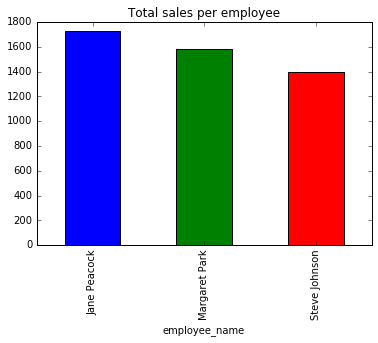

In [56]:
employee_sales["total_sales"].plot.bar(title="Total sales per employee")

Jane is the most productive sales rep with $1731.51 in sales.

In [57]:
q_country_customer = """
WITH by_customer AS
(
SELECT
    c.customer_id,
    CASE
        WHEN (SELECT COUNT(*) FROM customer WHERE country = c.country) = 1 THEN "Other countries"
        ELSE c.country
    END AS country,
    COUNT(i.invoice_id) number_of_order,
    SUM(i.total) as purchases
FROM customer c
INNER JOIN invoice i
ON c.customer_id = i.customer_id
GROUP BY c.customer_id
)

SELECT
    country,
    COUNT(customer_id) as number_of_customers,
    SUM(purchases) as total_sales,
    SUM(purchases) / COUNT(customer_id) as avg_sales_per_customer,
    SUM(purchases) / SUM(number_of_order) as avg_order_value,
    CASE
        WHEN country = "Other countries" THEN 1
        ELSE 0
    END AS sort
FROM by_customer
GROUP BY 1
ORDER BY sort ASC, 3 DESC;
"""
show_table(q_country_customer)

,country,number_of_customers,total_sales,avg_sales_per_customer,avg_order_value,sort
0,USA,13,1040.49,80.037692,7.942672,0
1,Canada,8,535.59,66.948750,7.047237,0
2,Brazil,5,427.68,85.536000,7.011148,0
3,France,5,389.07,77.814000,7.781400,0
4,Germany,4,334.62,83.655000,8.161463,0
5,Czech Republic,2,273.24,136.620000,9.108000,0
6,United Kingdom,3,245.52,81.840000,8.768571,0
7,Portugal,2,185.13,92.565000,6.383793,0
8,India,2,183.15,91.575000,8.721429,0
9,Other countries,15,1094.94,72.996000,7.448571,1


In [58]:
country_analysis = run_query(q_country_customer)
country_analysis.set_index("country", drop=True, inplace=True)
country_analysis.head()

,number_of_customers,total_sales,avg_sales_per_customer,avg_order_value,sort
country,,,,,
USA,13,1040.49,80.037692,7.942672,0
Canada,8,535.59,66.948750,7.047237,0
Brazil,5,427.68,85.536000,7.011148,0
France,5,389.07,77.814000,7.781400,0
Germany,4,334.62,83.655000,8.161463,0


(6, 10)

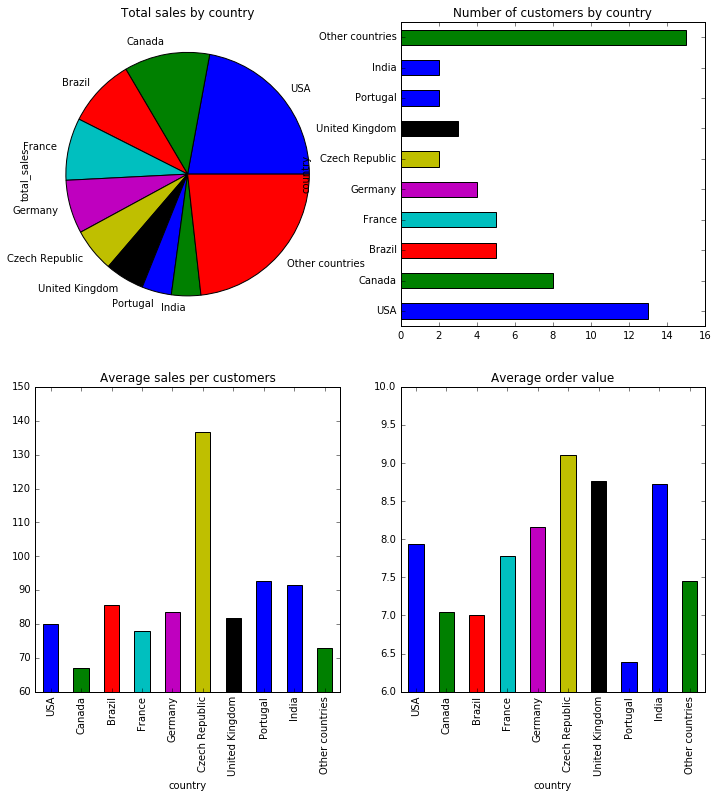

In [59]:
import numpy as np
fig, ax = plt.subplots(2, 2, figsize=(12,12))
ax1, ax2, ax3, ax4 = ax.flatten()

country_analysis["total_sales"].plot.pie(ax=ax1, title="Total sales by country", fontsize=10)

country_analysis["number_of_customers"].plot.barh(ax=ax2, title="Number of customers by country", fontsize=10)

country_analysis["avg_sales_per_customer"].plot.bar(ax=ax3, title="Average sales per customers", fontsize=10)
ax3.set_ylim(60,150)

country_analysis["avg_order_value"].plot.bar(ax=ax4, title="Average order value", fontsize=10)
ax4.set_ylim(6,10)

1) USA, Canada are top two countries with highest sales
2) USA, Canada, and Brazil have highest number of customers from each country
3) Czech Republic has the highest sales per customer
4) Czech Republic, UK, and India have the highest average order value

q_album_or_not = """
WITH invoice_analysis AS
(
SELECT
    i.*,
    il.*
FROM invoice i
INNER JOIN invoice_line il
ON il.invoice_id = i.invoice_id)

album_reference AS
(
SELECT
    a.*,
    t.*
FROM album a
INNER JOIN track t
ON a.album_id = t.album_id)



In [67]:
q_album_analysis = """
WITH invoice_first_track AS
(
SELECT
    il.invoice_id,
    MIN(il.track_id) first_track_id
FROM invoice_line il
GROUP BY 1
),


album_decide AS
(
SELECT
    ift.*,
    CASE
        WHEN
            (
            SELECT t.track_id FROM track t
            WHERE t.album_id = (
                    SELECT t2.album_id FROM track t2
                    Where t2.track_id = ift.first_track_id
                    )
                    
            EXCEPT

            SELECT il2.track_id FROM invoice_line il2
            WHERE il2.invoice_id = ift.invoice_id
            )

        IS NULL

        AND

            (
            SELECT il2.track_id FROM invoice_line il2
            WHERE il2.invoice_id = ift.invoice_id
    
            EXCEPT
    
            SELECT t.track_id FROM track t
            WHERE t.album_id = (
                        SELECT t2.album_id FROM track t2
                        WHERE t2.track_id = ift.first_track_id
                        )
            )
        IS NULL
        THEN "Yes"
        ELSE "NO"
        END AS Purchased_whole_album
FROM invoice_first_track ift
)

SELECT
    Purchased_whole_album,
    COUNT(invoice_id) as number_of_invoices,
    CAST(COUNT(invoice_id) as FLOAT)/ (SELECT COUNT(*) FROM invoice) as pct_of_invoice
FROM album_decide 
GROUP BY 1
"""
show_table(q_album_analysis)

,Purchased_whole_album,number_of_invoices,pct_of_invoice
0,NO,500,0.814332
1,Yes,114,0.185668


Key finding: 81% of the transactions are purchase of individual tracks, while 19% are the purchase of entire albums. This means the company should execute its strategy of buying tracks instead of albums from label companies. 